In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
data = sm.datasets.get_rdataset("dietox", "geepack").data
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit()
print(mdf.summary())

AssertionError: 

In [3]:
data.type

AttributeError: 'DataFrame' object has no attribute 'type'

In [1]:
import glob
import h5py
import librosa
import numpy as np
import os
import scipy
import sklearn
import sys
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("..")
import localmodule


In [15]:
data_dir = localmodule.get_data_dir()
participant_paths = glob.glob("imitations_participant*.mat")
participant_paths.sort()
n_participants = len(participant_paths)
n_imitations = 100
imitation_matrix = []
species_matrix = []

for participant_path in tqdm.tqdm(participant_paths):
    imitation_list = []
    species_list = []
    
    with h5py.File(participant_path) as h5_file:
        for i in range(n_imitations):
            imitation_waveform = h5_file['#refs#'][
                h5_file["imitations"]["imitationAudio"][i][0]][0]
            species = int(h5_file['#refs#'][
                h5_file["imitations"]["species"][i][0]][0][0])
            imitation_list.append(imitation_waveform)
            species_list.append(species)
        imitation_matrix.append(imitation_list)
        species_matrix.append(species_list)
imitation_matrix = np.array(imitation_matrix)
species_matrix = np.array(species_matrix)

100%|██████████| 17/17 [00:12<00:00,  1.40it/s]


In [6]:
participant_id = 0
imitation_id = 0
hop_length = 512
half_event_length = 4096
sr = 44100
n_events = 2
n_mfcc = 12

mfcc_tensor = np.zeros((n_mfcc, n_events, n_participants, n_imitations))

for participant_id in tqdm.tqdm(range(n_participants)):
    for imitation_id in range(n_imitations):
        imitation_waveform = imitation_matrix[participant_id, imitation_id]

        rms = np.ravel(librosa.feature.rmse(
            imitation_waveform, frame_length=2*hop_length, hop_length=hop_length))
        sorting_indices = rms.argsort(axis=0)[::-1]

        for event_id in range(n_events):
            event_start = max(0, sorting_indices[event_id] * hop_length - half_event_length)
            event_stop = min(len(imitation_waveform),
                             sorting_indices[event_id] * hop_length + half_event_length)
            event_length = event_stop - event_start
            event_waveform = imitation_waveform[event_start:event_stop] * scipy.signal.hann(event_length)
            mfcc = librosa.feature.mfcc(y=event_waveform, n_mels=40, n_mfcc=(1+n_mfcc), sr=sr)[1:, :]
            mfcc_tensor[:, event_id, participant_id, imitation_id] = np.mean(mfcc, axis=1)
            
species_tensor = np.tile(species_matrix, (n_events, 1, 1))
mfcc_X = np.reshape(mfcc_tensor, (n_mfcc, n_events*n_participants*n_imitations)).T
mfcc_y = np.ravel(species_tensor) - 1

100%|██████████| 17/17 [00:09<00:00,  1.85it/s]


In [7]:
# Principal component analysis

pca_model = sklearn.decomposition.PCA().fit(mfcc_X)
pca_X = pca_model.transform(mfcc_X)

Text(0, 0.5, 'PC 2')

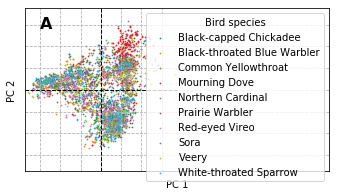

In [13]:

marker_size = 2
plt.figure(figsize=(12,3))
metadata_path = 'BirdVox-imitation_metadata.mat'

xmax = 10*(np.max(10+np.abs(pca_X))//10)
n_species = len(np.unique(species_tensor))

with h5py.File(metadata_path) as h5_file:
    species_strings = [
        " ".join([x.capitalize() for x in
        "".join(list(map(chr, h5_file["#refs#"][h5_file["meta"]["species"]["speciesName"][i][0]][:]))).split("_")])
         for i in range(n_species)
    ]

ax1 = plt.subplot(1,2,1)
ax1.text(0.05, .95, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')
plt.plot([0, 0], [-75, 75], '--', color='k', linewidth=1.0)
plt.plot([-75, 75], [0, 0], '--', color='k', linewidth=1.0)
for species_id in range(n_species): # 3 is kind of in one quadrent
    plt.scatter(
        pca_X[mfcc_y==species_id, 0], pca_X[mfcc_y==species_id, 1],
        marker='.', alpha=1.0, cmap='Set1', 
        label=species_strings[species_id],
        #label=species_names_with_sci_names[species_id],
        s=marker_size)
plt.gca().set_xticks(range(-60, 80, 20))
plt.gca().set_yticks(range(-60, 80, 20))
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.xlim(-75, 225)
plt.ylim(-75, 75)
plt.legend(title="Bird species")
plt.grid(linestyle='--')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

t = np.linspace(-1, 4,1000)
x = np.sin(t)

plt.plot(t,x)

In [ ]:
degree = 2
[a,b,c] = np.polyfit(t,x,degree)

In [ ]:
x[499]

In [ ]:
t = np.linspace(-10,10, 100)
a = -1
b = 1
c = 1000

xx = a*t**2 + b*t + c
plt.plot(t,xx)

peak_pit = -b/(2*a)
peak_pit_ind = (np.argmin(np.abs(t-peak_pit)))
print(peak_pit, peak_pit_ind)

plt.plot(peak_pit, xx[peak_pit_ind], 'o')

In [ ]:

#peak_pit = -b/(2*a)

for b in np.arange(-10,-1):
    xx = a*t**2 + b*t + c
    plt.plot(t,xx)
    #plt.hold(True)
    #plt.pause(1.2)
    #plt.show()
    #time.sleep(.2)
              
print(peak_pit, c)

In [ ]:
x[1]






















